# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


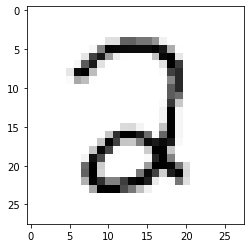

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.2491
Training Accuracy: 0.6168, Testing Accuracy: 0.5907



Epoch 10, Loss 0.0947
Training Accuracy: 0.9150, Testing Accuracy: 0.9274



Epoch 20, Loss 0.0564
Training Accuracy: 0.9433, Testing Accuracy: 0.9531



Epoch 30, Loss 0.0437
Training Accuracy: 0.9528, Testing Accuracy: 0.9602



Epoch 40, Loss 0.0375
Training Accuracy: 0.9586, Testing Accuracy: 0.9662



Epoch 50, Loss 0.0337
Training Accuracy: 0.9625, Testing Accuracy: 0.9672



Epoch 60, Loss 0.0312
Training Accuracy: 0.9644, Testing Accuracy: 0.9688



Epoch 70, Loss 0.0293
Training Accuracy: 0.9658, Testing Accuracy: 0.9723



Epoch 80, Loss 0.0279
Training Accuracy: 0.9678, Testing Accuracy: 0.9733



Epoch 90, Loss 0.0267
Training Accuracy: 0.9687, Testing Accuracy: 0.9748



Epoch 100, Loss 0.0257
Training Accuracy: 0.9698, Testing Accuracy: 0.9753



Epoch 110, Loss 0.0248
Training Accuracy: 0.9710, Testing Accuracy: 0.9753



Epoch 120, Loss 0.024
Training Accuracy: 0.9716, Testing Accuracy: 0.9748



Epoch 130, Loss 0.0233
Training Accuracy: 0.9729, Testing Accuracy: 0.9743



Epoch 140, Loss 0.0226
Training Accuracy: 0.9738, Testing Accuracy: 0.9743



Epoch 150, Loss 0.022
Training Accuracy: 0.9745, Testing Accuracy: 0.9748



Epoch 160, Loss 0.0214
Training Accuracy: 0.9753, Testing Accuracy: 0.9753



Epoch 170, Loss 0.0209
Training Accuracy: 0.9756, Testing Accuracy: 0.9743



Epoch 180, Loss 0.0204
Training Accuracy: 0.9760, Testing Accuracy: 0.9753



Epoch 190, Loss 0.0199
Training Accuracy: 0.9772, Testing Accuracy: 0.9753



Epoch 200, Loss 0.0194
Training Accuracy: 0.9781, Testing Accuracy: 0.9753



Epoch 210, Loss 0.0189
Training Accuracy: 0.9787, Testing Accuracy: 0.9753



Epoch 220, Loss 0.0185
Training Accuracy: 0.9795, Testing Accuracy: 0.9758



Epoch 230, Loss 0.0181
Training Accuracy: 0.9803, Testing Accuracy: 0.9758



Epoch 240, Loss 0.0177
Training Accuracy: 0.9808, Testing Accuracy: 0.9768



0.0344018556902782

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.2594
Training Accuracy: 0.6153, Testing Accuracy: 0.6174



Epoch 10, Loss 0.1019
Training Accuracy: 0.9156, Testing Accuracy: 0.9289



Epoch 20, Loss 0.0783
Training Accuracy: 0.9316, Testing Accuracy: 0.9430



Epoch 30, Loss 0.0675
Training Accuracy: 0.9371, Testing Accuracy: 0.9496



Epoch 40, Loss 0.061
Training Accuracy: 0.9426, Testing Accuracy: 0.9551



Epoch 50, Loss 0.0566
Training Accuracy: 0.9458, Testing Accuracy: 0.9582



Epoch 60, Loss 0.0534
Training Accuracy: 0.9483, Testing Accuracy: 0.9587



Epoch 70, Loss 0.0509
Training Accuracy: 0.9499, Testing Accuracy: 0.9597



Epoch 80, Loss 0.0489
Training Accuracy: 0.9513, Testing Accuracy: 0.9617



Epoch 90, Loss 0.0472
Training Accuracy: 0.9525, Testing Accuracy: 0.9632



Epoch 100, Loss 0.0458
Training Accuracy: 0.9539, Testing Accuracy: 0.9642



Epoch 110, Loss 0.0446
Training Accuracy: 0.9547, Testing Accuracy: 0.9657



Epoch 120, Loss 0.0436
Training Accuracy: 0.9554, Testing Accuracy: 0.9657



Epoch 130, Loss 0.0427
Training Accuracy: 0.9563, Testing Accuracy: 0.9667



Epoch 140, Loss 0.0418
Training Accuracy: 0.9569, Testing Accuracy: 0.9667



Epoch 150, Loss 0.0411
Training Accuracy: 0.9575, Testing Accuracy: 0.9677



Epoch 160, Loss 0.0404
Training Accuracy: 0.9582, Testing Accuracy: 0.9677



Epoch 170, Loss 0.0398
Training Accuracy: 0.9587, Testing Accuracy: 0.9677



Epoch 180, Loss 0.0393
Training Accuracy: 0.9589, Testing Accuracy: 0.9682



Epoch 190, Loss 0.0388
Training Accuracy: 0.9598, Testing Accuracy: 0.9672



Epoch 200, Loss 0.0383
Training Accuracy: 0.9603, Testing Accuracy: 0.9672



Epoch 210, Loss 0.0379
Training Accuracy: 0.9609, Testing Accuracy: 0.9672



Epoch 220, Loss 0.0375
Training Accuracy: 0.9610, Testing Accuracy: 0.9677



Epoch 230, Loss 0.0371
Training Accuracy: 0.9613, Testing Accuracy: 0.9672



Epoch 240, Loss 0.0367
Training Accuracy: 0.9614, Testing Accuracy: 0.9672



0.010784317780771178

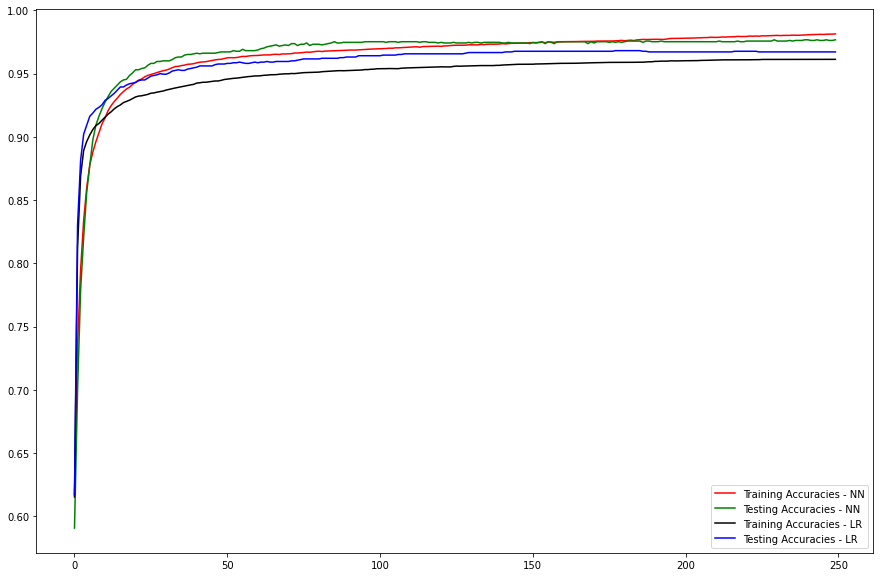

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

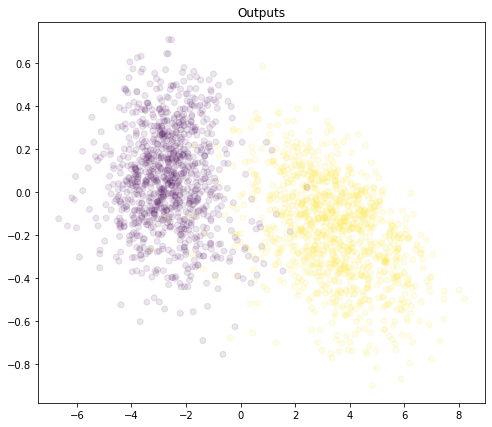

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

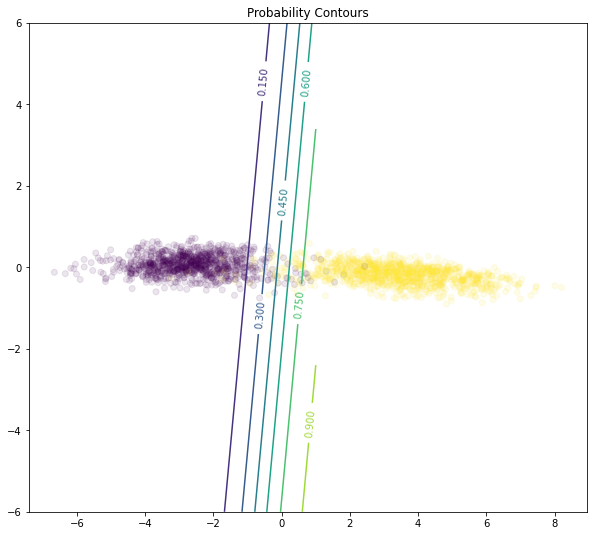

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );